In [1]:
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.data_handling import load_adi_data
from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask
from s4hci.utils.s4_rigde import compute_betas_least_square, compute_betas_svd
from s4hci.utils.positions import get_validation_positions

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG")

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
X_train = science_data[0::2]
X_test = science_data[1::2]
angles_train = raw_angles[0::2]
angles_test = raw_angles[1::2]

In [4]:
del science_data
del raw_angles
del raw_psf_template_data

## Load the code

In [5]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask
from s4hci.utils.s4_rigde import compute_betas_least_square, compute_betas_svd
from s4hci.utils.positions import get_validation_positions


class S4Noise(nn.Module):

    def __init__(
            self,
            data_image_size,
            psf_template,
            lambda_reg,
            cut_radius_psf,
            mask_template_setup,
            convolve=True,
            re_mask=False,
            verbose=True,
            available_device="cpu"):

        super(S4Noise, self).__init__()

        # 1.) save the non-model related parameters
        self.available_device = available_device
        self.verbose = verbose

        # 2.) save the simple information
        self.image_size = data_image_size
        self.lambda_reg = lambda_reg
        self.convolve = convolve
        self.cut_radius_psf = cut_radius_psf
        self.mask_template_setup = mask_template_setup
        self.re_mask = re_mask

        # 3.) prepare the psf_template
        template_cut, _ = construct_round_rfrr_template(
            radius=self.cut_radius_psf,
            psf_template_in=psf_template)

        template_norm = template_cut / np.max(np.abs(template_cut))

        self.register_buffer(
            "psf_model",
            torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0))

        # 4.) Initialize the raw beta values
        self.betas_raw = nn.Parameter(torch.zeros(
            self.image_size ** 2, self.image_size ** 2,
            dtype=torch.double))

        self.prev_betas = None

        # 5.) Set up the buffers for the two masks
        if self.verbose:
            print("Creating right reason mask ... ", end='')

        right_reason_mask = construct_rfrr_mask(
            template_setup=self.mask_template_setup,
            psf_template_in=template_norm,
            mask_size_in=self.image_size)

        self.register_buffer(
            "right_reason_mask",
            torch.from_numpy(right_reason_mask))

        second_mask = construct_rfrr_mask(
            template_setup=self.mask_template_setup,
            psf_template_in=template_norm,
            mask_size_in=self.image_size,
            use_template=True)

        self.register_buffer(
            "second_mask",
            torch.from_numpy(second_mask))

        if self.verbose:
            print("[DONE]")

        # 6.) Set up the buffers for the normalization
        self.register_buffer(
            "mean_frame",
            torch.zeros(
                self.image_size,
                self.image_size,
                dtype=torch.double))

        self.register_buffer(
            "std_frame",
            torch.zeros(
                self.image_size,
                self.image_size,
                dtype=torch.double))

    def save(self, file_path):
        state_dict = self.state_dict()

        # add the other information we want to keep
        state_dict["image_size"] = self.image_size
        state_dict["lambda_reg"] = self.lambda_reg
        state_dict["convolve"] = self.convolve
        state_dict["cut_radius_psf"] = self.cut_radius_psf
        state_dict["mask_template_setup"] = self.mask_template_setup
        state_dict["re_mask"] = self.re_mask
        torch.save(state_dict, file_path)

    @classmethod
    def load(
            cls,
            file_path,
            verbose=True,
            available_device="cpu"):

        state_dict = torch.load(file_path)

        # create a dummy psf template
        psf_size = state_dict["psf_model"].shape[-1]
        dummy_template = np.ones((psf_size, psf_size))

        obj = cls(
            data_image_size=state_dict.pop('image_size'),
            psf_template=dummy_template,
            lambda_reg=state_dict.pop('lambda_reg'),
            cut_radius_psf=state_dict.pop('cut_radius_psf'),
            mask_template_setup=state_dict.pop('mask_template_setup'),
            convolve=state_dict.pop('convolve'),
            re_mask=state_dict.pop('re_mask'),
            verbose=verbose,
            available_device=available_device)

        obj.load_state_dict(state_dict)
        return obj

    def _prepare_normalization(
            self,
            science_data):

        if self.verbose:
            print("Build normalization frames ... ", end='')

        self.mean_frame = torch.mean(science_data, axis=0)
        self.std_frame = torch.std(science_data, axis=0)

        if self.verbose:
            print("[DONE]")

    def normalize_data(self, science_data):
        science_data_mean_shift = science_data - self.mean_frame
        return science_data_mean_shift / self.std_frame

    def fit(
            self,
            science_data):

        self._prepare_normalization(science_data)
        science_data_norm = self.normalize_data(science_data)

        positions = [(x, y)
                     for x in range(self.image_size)
                     for y in range(self.image_size)]

        if self.verbose:
            print("Fitting ... ", end='')

        # 2.) Fit all positions
        if self.convolve:
            p_torch = self.psf_model
        else:
            p_torch = None

        self.betas_raw.data = compute_betas_least_square(
            X_torch=science_data_norm,
            p_torch=p_torch,
            M_torch=self.right_reason_mask,
            lambda_reg=self.lambda_reg,
            positions=positions,
            verbose=self.verbose)

        if self.verbose:
            print("[DONE]")

    def _validate_lambdas_separation(
            self,
            separation,
            lambdas,
            science_data_train,
            science_data_test,
            num_test_positions,
            approx_svd=-1
    ):

        # 1.) get the positions where we evaluate the residual error
        if self.verbose:
            print("Compute validation positions for "
                  "separation " + str(separation) + " ...")

        positions = get_validation_positions(
            num_positions=num_test_positions,
            separation=separation,
            test_image=science_data_train[0].cpu().numpy())

        # 2.) Set up the training data
        if self.verbose:
            print("Setup training data for "
                  "separation " + str(separation) + " ...")

        self._prepare_normalization(science_data_train)
        science_data_norm = self.normalize_data(science_data_train)

        # 3.) Compute the betas
        # collect all parameters for the SVD
        if self.verbose:
            print("Compute betas for "
                  "separation " + str(separation) + " ...")

        if self.convolve:
            p_torch = self.psf_model
        else:
            p_torch = None

        betas_conv = compute_betas_svd(
            X_torch=science_data_norm,
            M_torch=self.right_reason_mask,
            lambda_regs=lambdas,
            positions=positions,
            p_torch=p_torch,
            approx_svd=approx_svd,
            verbose=self.verbose)

        # 4.) Re-mask with self.second_mask.
        # This step is needed to cut off overflow towards the identity in case
        # of small mask sizes
        if self.verbose:
            print("Re-mask betas for "
                  "separation " + str(separation) + " ...")

        re_masked = torch.zeros_like(betas_conv)
        all_idx = []
        for i, tmp_position in enumerate(positions):
            x, y = tmp_position
            tmp_idx = x * self.image_size + y
            all_idx.append(tmp_idx)

            re_masked[i] = betas_conv[i] * self.second_mask[tmp_idx]

        # 5.) Predict
        if self.verbose:
            print("Compute validation errors for "
                  "separation " + str(separation) + " ...")

        science_test = science_data_test
        science_test = self.normalize_data(science_test)

        science_test = science_test.view(science_test.shape[0], -1)
        gt_values = science_test[:, all_idx]

        median_errors = []

        for tmp_lambda_idx in tqdm(range(re_masked.shape[1])):
            tmp_beta = re_masked[:, tmp_lambda_idx]
            tmp_beta = tmp_beta.view(tmp_beta.shape[0], -1)

            tmp_prediction = science_test @ tmp_beta.T
            tmp_residual = torch.abs(gt_values - tmp_prediction)

            tmp_median_error = torch.median(tmp_residual)
            median_errors.append(tmp_median_error.cpu())

        # normalize
        median_errors = np.array(median_errors)
        median_errors -= np.mean(median_errors)
        median_errors /= np.std(median_errors)

        return median_errors

    def validate_lambdas(
            self,
            num_separations,
            lambdas,
            science_data_train,
            science_data_test,
            num_test_positions,
            approx_svd=-1
    ):
        test_image = science_data_train[0]
        image_size_radius = int((test_image.shape[0] - 1) / 2)

        separations = np.linspace(0, image_size_radius, num_separations + 1,
                                  endpoint=False)[1:]

        all_results = dict()
        for tmp_separation in separations:
            tmp_errors = self._validate_lambdas_separation(
                separation=tmp_separation,
                lambdas=lambdas,
                science_data_train=science_data_train,
                science_data_test=science_data_test,
                num_test_positions=num_test_positions,
                approx_svd=approx_svd
            )
            all_results[tmp_separation] = tmp_errors

        # find the best lambda
        merged_results = np.array([i for i in all_results.values()])
        median_result = np.median(merged_results, axis=0)

        best_lambda_idx = np.argmin(median_result)
        best_lambda = lambdas[best_lambda_idx]

        if self.verbose:
            print("Recommended Lambda = {:.2f}".format(best_lambda))
            print("Make sure to check if the tested range of lambda values is "
                  "covering the global minimum!")

        self.lambda_reg = best_lambda

        return all_results, best_lambda

    @property
    def betas(self):
        if self.prev_betas is None:
            self.compute_betas()

        return self.prev_betas

    def compute_betas(self):
        # reshape the raw betas
        raw_betas = self.betas_raw.view(
            -1,
            self.image_size,
            self.image_size)

        # set regularization_mask values to zero
        tmp_weights = raw_betas * self.right_reason_mask

        # convolve the weights
        tmp_weights = F.conv2d(
            tmp_weights.unsqueeze(1),
            self.psf_model,
            padding="same").view(
            self.image_size ** 2,
            self.image_size ** 2)

        if self.re_mask:
            tmp_weights = tmp_weights * self.second_mask.flatten(start_dim=1)

        self.prev_betas = tmp_weights

    def predict(
            self,
            science_data
    ):
        """
        science_data: shape: (time, x, y), not normalized raw data
        """

        # 1.) normalize the science_data
        science_norm = self.normalize_data(science_data)

        # 2.) predict the noise
        with torch.no_grad():
            science_norm_flatten = science_norm.view(
                science_norm.shape[0], -1)

            noise_estimate = self.forward(science_norm_flatten)

        # 3.) compute the residual
        residual = science_norm_flatten - noise_estimate

        residual = residual.view(
            science_norm.shape[0],
            self.image_size,
            self.image_size)

        noise_estimate = noise_estimate.view(
            science_norm.shape[0],
            self.image_size,
            self.image_size)

        return residual, noise_estimate

    def forward(
            self,
            science_norm_flatten: torch.Tensor
    ) -> torch.Tensor:
        """
        science_norm_flatten: shape: (time, x*y) already normalized
        """

        noise_estimate = science_norm_flatten @ self.betas.T

        return noise_estimate


## Load the pre-trained model

In [6]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_2.pkl")

s4_noise_loaded = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


## Run some simple training

In [7]:
import torch
from torch import nn
from torch import optim

In [8]:
X_train_torch = torch.from_numpy(X_train)#.float()
s4_noise_loaded = s4_noise_loaded#.float()

In [9]:
s4_noise_loaded = s4_noise_loaded.to(0)
X_train_torch = X_train_torch.to(0)

In [10]:
torch.set_float32_matmul_precision("high")

In [11]:
# Normalize the data
science_norm = s4_noise_loaded.normalize_data(X_train_torch)

# reshape the science data
science_norm_flatten = science_norm.view(
    science_norm.shape[0], -1)

In [12]:
optimizer = optim.SGD(
    [s4_noise_loaded.betas_raw,],
    lr=1e-3,
    momentum=0.9)

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]

1.160670280456543
60.2990608215332
---


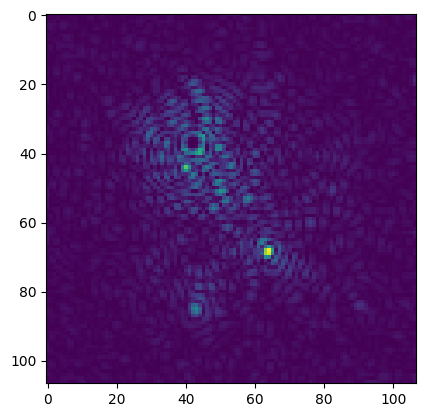

  0%|▋                                                                                                                                                                      | 2/500 [00:00<03:36,  2.30it/s]

1.1203566789627075
60.29669952392578
---


  1%|█                                                                                                                                                                      | 3/500 [00:01<03:26,  2.41it/s]

1.118394136428833
60.29220962524414
---


  1%|█▎                                                                                                                                                                     | 4/500 [00:01<03:21,  2.46it/s]

1.1454628705978394
60.28580093383789
---


  1%|█▋                                                                                                                                                                     | 5/500 [00:02<03:18,  2.49it/s]

1.1389344930648804
60.27766036987305
---


  1%|██                                                                                                                                                                     | 6/500 [00:02<03:16,  2.51it/s]

1.1124013662338257
60.26795959472656
---


  1%|██▎                                                                                                                                                                    | 7/500 [00:02<03:15,  2.53it/s]

1.1154245138168335
60.25685119628906
---


  2%|██▋                                                                                                                                                                    | 8/500 [00:03<03:14,  2.53it/s]

1.1324028968811035
60.2445068359375
---


  2%|███                                                                                                                                                                    | 9/500 [00:03<03:13,  2.54it/s]

1.124632477760315
60.23103332519531
---


  2%|███▎                                                                                                                                                                  | 10/500 [00:04<03:12,  2.54it/s]

1.1083855628967285
60.21654510498047
---


  2%|███▋                                                                                                                                                                  | 11/500 [00:04<03:12,  2.54it/s]

1.1134079694747925
60.20114517211914
---


  2%|███▉                                                                                                                                                                  | 12/500 [00:04<03:11,  2.54it/s]

1.1236056089401245
60.18492126464844
---


  3%|████▎                                                                                                                                                                 | 13/500 [00:05<03:11,  2.55it/s]

1.116308331489563
60.167945861816406
---


  3%|████▋                                                                                                                                                                 | 14/500 [00:05<03:10,  2.55it/s]

1.106667160987854
60.150306701660156
---


  3%|████▉                                                                                                                                                                 | 15/500 [00:05<03:10,  2.55it/s]

1.1115083694458008
60.13207244873047
---


  3%|█████▎                                                                                                                                                                | 16/500 [00:06<03:10,  2.55it/s]

1.1169623136520386
60.11330032348633
---


  3%|█████▋                                                                                                                                                                | 17/500 [00:06<03:09,  2.55it/s]

1.110722541809082
60.094058990478516
---


  4%|█████▉                                                                                                                                                                | 18/500 [00:07<03:09,  2.55it/s]

1.105165958404541
60.07438278198242
---


  4%|██████▎                                                                                                                                                               | 19/500 [00:07<03:08,  2.55it/s]

1.1091532707214355
60.05431365966797
---


  4%|██████▋                                                                                                                                                               | 20/500 [00:07<03:08,  2.55it/s]

1.1118190288543701
60.03389358520508
---


  4%|██████▉                                                                                                                                                               | 21/500 [00:08<03:07,  2.55it/s]

1.107047200202942
60.01316452026367
---


  4%|███████▎                                                                                                                                                              | 22/500 [00:08<03:07,  2.55it/s]

1.1042231321334839
59.99214172363281
---


  5%|███████▋                                                                                                                                                              | 23/500 [00:09<03:07,  2.55it/s]

1.1073845624923706
59.97087860107422
---


  5%|███████▉                                                                                                                                                              | 24/500 [00:09<03:06,  2.55it/s]

1.108550786972046
59.94938659667969
---


  5%|████████▎                                                                                                                                                             | 25/500 [00:09<03:06,  2.55it/s]

1.1051719188690186
59.927696228027344
---


  5%|████████▋                                                                                                                                                             | 26/500 [00:10<03:06,  2.55it/s]

1.103901743888855
59.90582275390625
---


  5%|████████▉                                                                                                                                                             | 27/500 [00:10<03:05,  2.55it/s]

1.1061924695968628
59.883792877197266
---


  6%|█████████▎                                                                                                                                                            | 28/500 [00:11<03:05,  2.55it/s]

1.1064603328704834
59.861610412597656
---


  6%|█████████▋                                                                                                                                                            | 29/500 [00:11<03:04,  2.55it/s]

1.1040536165237427
59.83929443359375
---


  6%|█████████▉                                                                                                                                                            | 30/500 [00:11<03:04,  2.54it/s]

1.1035751104354858
59.81686782836914
---


  6%|██████████▎                                                                                                                                                           | 31/500 [00:12<03:04,  2.55it/s]

1.1050758361816406
59.794334411621094
---


  6%|██████████▌                                                                                                                                                           | 32/500 [00:12<03:03,  2.55it/s]

1.1048592329025269
59.77171325683594
---


  7%|██████████▉                                                                                                                                                           | 33/500 [00:13<03:03,  2.55it/s]

1.1032272577285767
59.7490119934082
---


  7%|███████████▎                                                                                                                                                          | 34/500 [00:13<03:03,  2.55it/s]

1.1031465530395508
59.726234436035156
---


  7%|███████████▌                                                                                                                                                          | 35/500 [00:13<03:02,  2.55it/s]

1.104107141494751
59.703392028808594
---


  7%|███████████▉                                                                                                                                                          | 36/500 [00:14<03:02,  2.55it/s]

1.103756070137024
59.68050003051758
---


  7%|████████████▎                                                                                                                                                         | 37/500 [00:14<03:01,  2.55it/s]

1.1027181148529053
59.65754318237305
---


  8%|████████████▌                                                                                                                                                         | 38/500 [00:15<03:01,  2.55it/s]

1.102849006652832
59.63454818725586
---


  8%|████████████▉                                                                                                                                                         | 39/500 [00:15<03:00,  2.55it/s]

1.1034538745880127
59.61152267456055
---


  8%|█████████████▎                                                                                                                                                        | 40/500 [00:15<03:00,  2.55it/s]

1.1030809879302979
59.58844757080078
---


  8%|█████████████▌                                                                                                                                                        | 41/500 [00:16<03:00,  2.55it/s]

1.1024380922317505
59.56534957885742
---


  8%|█████████████▉                                                                                                                                                        | 42/500 [00:16<02:59,  2.55it/s]

1.1026203632354736
59.54222106933594
---


  9%|██████████████▎                                                                                                                                                       | 43/500 [00:16<02:59,  2.55it/s]

1.102952003479004
59.51908874511719
---


  9%|██████████████▌                                                                                                                                                       | 44/500 [00:17<02:58,  2.55it/s]

1.1026155948638916
59.49591827392578
---


  9%|██████████████▉                                                                                                                                                       | 45/500 [00:17<02:58,  2.55it/s]

1.102226734161377
59.47272872924805
---


  9%|███████████████▎                                                                                                                                                      | 46/500 [00:18<02:58,  2.55it/s]

1.1023963689804077
59.44953155517578
---


  9%|███████████████▌                                                                                                                                                      | 47/500 [00:18<02:57,  2.55it/s]

1.1025676727294922
59.426326751708984
---


 10%|███████████████▉                                                                                                                                                      | 48/500 [00:18<02:57,  2.54it/s]

1.102295994758606
59.40310287475586
---


 10%|████████████████▎                                                                                                                                                     | 49/500 [00:19<02:57,  2.54it/s]

1.1020758152008057
59.379886627197266
---
1.1022205352783203
59.356651306152344
---


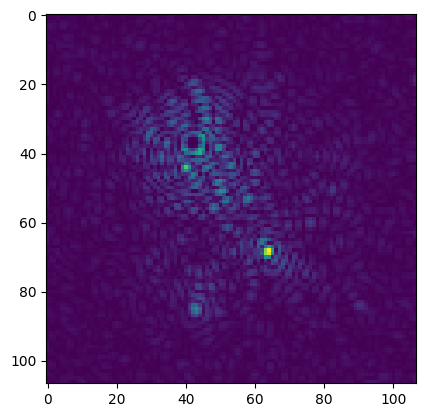

 10%|████████████████▉                                                                                                                                                     | 51/500 [00:20<03:06,  2.41it/s]

1.1022987365722656
59.333412170410156
---


 10%|█████████████████▎                                                                                                                                                    | 52/500 [00:20<03:02,  2.45it/s]

1.1021007299423218
59.310176849365234
---


 11%|█████████████████▌                                                                                                                                                    | 53/500 [00:21<03:00,  2.48it/s]

1.101988673210144
59.286930084228516
---


 11%|█████████████████▉                                                                                                                                                    | 54/500 [00:21<02:58,  2.49it/s]

1.102101445198059
59.26368713378906
---


 11%|██████████████████▎                                                                                                                                                   | 55/500 [00:21<02:57,  2.51it/s]

1.102124810218811
59.24044418334961
---


 11%|██████████████████▌                                                                                                                                                   | 56/500 [00:22<02:56,  2.52it/s]

1.1019830703735352
59.217201232910156
---


 11%|██████████████████▉                                                                                                                                                   | 57/500 [00:22<02:55,  2.52it/s]

1.1019271612167358
59.19396209716797
---


 12%|███████████████████▎                                                                                                                                                  | 58/500 [00:22<02:54,  2.53it/s]

1.1020020246505737
59.17072677612305
---


 12%|███████████████████▌                                                                                                                                                  | 59/500 [00:23<02:54,  2.53it/s]

1.10199773311615
59.147491455078125
---


 12%|███████████████████▉                                                                                                                                                  | 60/500 [00:23<02:53,  2.53it/s]

1.101897120475769
59.124263763427734
---


 12%|████████████████████▎                                                                                                                                                 | 61/500 [00:24<02:53,  2.53it/s]

1.1018749475479126
59.101036071777344
---


 12%|████████████████████▌                                                                                                                                                 | 62/500 [00:24<02:52,  2.54it/s]

1.1019282341003418
59.07781982421875
---


 13%|████████████████████▉                                                                                                                                                 | 63/500 [00:24<02:52,  2.54it/s]

1.1019108295440674
59.054603576660156
---


 13%|█████████████████████▏                                                                                                                                                | 64/500 [00:25<02:51,  2.54it/s]

1.101845622062683
59.03139114379883
---


 13%|█████████████████████▌                                                                                                                                                | 65/500 [00:25<02:51,  2.54it/s]

1.1018415689468384
59.0081901550293
---


 13%|█████████████████████▉                                                                                                                                                | 66/500 [00:26<02:50,  2.54it/s]

1.10187566280365
58.98499298095703
---


 13%|██████████████████████▏                                                                                                                                               | 67/500 [00:26<02:50,  2.54it/s]

1.1018587350845337
58.96179962158203
---


 14%|██████████████████████▌                                                                                                                                               | 68/500 [00:26<02:50,  2.54it/s]

1.1018197536468506
58.938621520996094
---


 14%|██████████████████████▉                                                                                                                                               | 69/500 [00:27<02:49,  2.54it/s]

1.101826548576355
58.915443420410156
---


 14%|███████████████████████▏                                                                                                                                              | 70/500 [00:27<02:49,  2.54it/s]

1.1018478870391846
58.89227294921875
---


 14%|███████████████████████▌                                                                                                                                              | 71/500 [00:28<02:48,  2.54it/s]

1.1018319129943848
58.86910629272461
---


 14%|███████████████████████▉                                                                                                                                              | 72/500 [00:28<02:48,  2.54it/s]

1.1018097400665283
58.84595489501953
---


 15%|████████████████████████▏                                                                                                                                             | 73/500 [00:28<02:48,  2.54it/s]

1.1018201112747192
58.82280349731445
---


 15%|████████████████████████▌                                                                                                                                             | 74/500 [00:29<02:47,  2.54it/s]

1.1018331050872803
58.7996711730957
---


 15%|████████████████████████▉                                                                                                                                             | 75/500 [00:29<02:47,  2.54it/s]

1.101823091506958
58.77653503417969
---


 15%|█████████████████████████▏                                                                                                                                            | 76/500 [00:30<02:47,  2.54it/s]

1.1018130779266357
58.753414154052734
---


 15%|█████████████████████████▌                                                                                                                                            | 77/500 [00:30<02:46,  2.54it/s]

1.1018248796463013
58.73029708862305
---


 16%|█████████████████████████▉                                                                                                                                            | 78/500 [00:30<02:46,  2.54it/s]

1.1018363237380981
58.70718765258789
---


 16%|██████████████████████████▏                                                                                                                                           | 79/500 [00:31<02:45,  2.54it/s]

1.1018314361572266
58.6840934753418
---


 16%|██████████████████████████▌                                                                                                                                           | 80/500 [00:31<02:45,  2.54it/s]

1.1018279790878296
58.6609992980957
---


 16%|██████████████████████████▉                                                                                                                                           | 81/500 [00:32<02:45,  2.54it/s]

1.1018404960632324
58.63792037963867
---


 16%|███████████████████████████▏                                                                                                                                          | 82/500 [00:32<02:44,  2.54it/s]

1.1018503904342651
58.614845275878906
---


 17%|███████████████████████████▌                                                                                                                                          | 83/500 [00:32<02:44,  2.54it/s]

1.1018489599227905
58.59177780151367
---


 17%|███████████████████████████▉                                                                                                                                          | 84/500 [00:33<02:44,  2.54it/s]

1.101852297782898
58.568729400634766
---


 17%|████████████████████████████▏                                                                                                                                         | 85/500 [00:33<02:43,  2.54it/s]

1.1018643379211426
58.545677185058594
---


 17%|████████████████████████████▌                                                                                                                                         | 86/500 [00:34<02:43,  2.54it/s]

1.1018749475479126
58.522640228271484
---


 17%|████████████████████████████▉                                                                                                                                         | 87/500 [00:34<02:42,  2.54it/s]

1.1018774509429932
58.49961471557617
---


 18%|█████████████████████████████▏                                                                                                                                        | 88/500 [00:34<02:42,  2.54it/s]

1.1018840074539185
58.47659683227539
---


 18%|█████████████████████████████▌                                                                                                                                        | 89/500 [00:35<02:41,  2.54it/s]

1.1018961668014526
58.45357894897461
---


 18%|█████████████████████████████▉                                                                                                                                        | 90/500 [00:35<02:41,  2.54it/s]

1.1019058227539062
58.43057632446289
---


 18%|██████████████████████████████▏                                                                                                                                       | 91/500 [00:35<02:41,  2.54it/s]

1.1019119024276733
58.407588958740234
---


 18%|██████████████████████████████▌                                                                                                                                       | 92/500 [00:36<02:40,  2.54it/s]

1.1019223928451538
58.38459396362305
---


 19%|██████████████████████████████▉                                                                                                                                       | 93/500 [00:36<02:40,  2.54it/s]

1.101935863494873
58.36161804199219
---


 19%|███████████████████████████████▏                                                                                                                                      | 94/500 [00:37<02:40,  2.54it/s]

1.1019445657730103
58.338661193847656
---


 19%|███████████████████████████████▌                                                                                                                                      | 95/500 [00:37<02:39,  2.54it/s]

1.1019543409347534
58.315696716308594
---


 19%|███████████████████████████████▊                                                                                                                                      | 96/500 [00:37<02:39,  2.54it/s]

1.101966142654419
58.292747497558594
---


 19%|████████████████████████████████▏                                                                                                                                     | 97/500 [00:38<02:38,  2.54it/s]

1.1019788980484009
58.269805908203125
---


 20%|████████████████████████████████▌                                                                                                                                     | 98/500 [00:38<02:38,  2.54it/s]

1.1019905805587769
58.24687194824219
---
1.1020021438598633
58.22394561767578
---


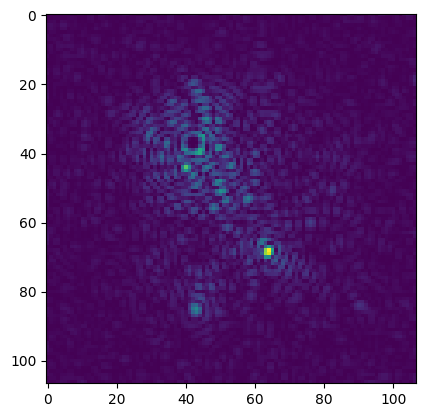

 20%|█████████████████████████████████                                                                                                                                    | 100/500 [00:39<02:46,  2.41it/s]

1.1020152568817139
58.20103454589844
---


 20%|█████████████████████████████████▎                                                                                                                                   | 101/500 [00:40<02:43,  2.44it/s]

1.1020301580429077
58.17813491821289
---


 20%|█████████████████████████████████▋                                                                                                                                   | 102/500 [00:40<02:41,  2.47it/s]

1.102042317390442
58.15523147583008
---


 21%|█████████████████████████████████▉                                                                                                                                   | 103/500 [00:40<02:39,  2.49it/s]

1.1020543575286865
58.132347106933594
---


 21%|██████████████████████████████████▎                                                                                                                                  | 104/500 [00:41<02:38,  2.50it/s]

1.1020692586898804
58.10947036743164
---


 21%|██████████████████████████████████▋                                                                                                                                  | 105/500 [00:41<02:37,  2.51it/s]

1.1020854711532593
58.08659744262695
---


 21%|██████████████████████████████████▉                                                                                                                                  | 106/500 [00:42<02:36,  2.52it/s]

1.1020982265472412
58.06373977661133
---


 21%|███████████████████████████████████▎                                                                                                                                 | 107/500 [00:42<02:35,  2.53it/s]

1.1021124124526978
58.0408821105957
---


 22%|███████████████████████████████████▋                                                                                                                                 | 108/500 [00:42<02:35,  2.53it/s]

1.1021281480789185
58.01803970336914
---


 22%|███████████████████████████████████▉                                                                                                                                 | 109/500 [00:43<02:34,  2.53it/s]

1.1021445989608765
57.995208740234375
---


 22%|████████████████████████████████████▎                                                                                                                                | 110/500 [00:43<02:34,  2.53it/s]

1.1021592617034912
57.97238540649414
---


 22%|████████████████████████████████████▎                                                                                                                                | 110/500 [00:43<02:35,  2.50it/s]


KeyboardInterrupt: 

In [61]:
for epoch in tqdm(range(500)):
    optimizer.zero_grad(set_to_none=True)
    
    # 1.) Compute Beta
    s4_noise_loaded.compute_betas()
    
    # 2.) run forward
    noise_estimate = s4_noise_loaded(science_norm_flatten)
     
    # 3.) Compute the loss       
    loss_recon = ((noise_estimate - science_norm_flatten)**2).sum()
    loss_reg = (s4_noise_loaded.betas_raw**2).sum()
    
    # 4.) Normalize the loss
    loss_normalization = s4_noise_loaded.image_size ** 4
    loss_recon /= loss_normalization
    loss_reg /= loss_normalization
    
    
    # 5.) Backward 
    loss = (loss_reg + loss_recon)
    loss.backward()
    
    optimizer.step()
    
    # 6.) Print the loss terms
    print(loss_recon.item())
    print(loss_reg.item())
    print("---")
    
    if epoch%49 == 0:
        
        tmp_weights = s4_noise_loaded.betas
        plt.imshow(torch.abs(tmp_weights[4001].view(107, 107).cpu().detach()))
        plt.show()

In [25]:
1.120345950126648 - 1.0964477062225342

0.02389824390411377

In [26]:
0.060299068689346313 - 0.06030326709151268

-4.198402166366577e-06

## Show how the loss changes if we adapt lambda

In [13]:
def fine_tune_model(
    model_in,
    training_data,
    lambda_factor=1,
    num_epochs=50):
    
    # Normalize the data
    science_norm = s4_noise_loaded.normalize_data(training_data)

    # reshape the science data
    science_norm_flatten = science_norm.view(
        science_norm.shape[0], -1)
    
    optimizer = optim.SGD(
        [model_in.betas_raw,],
        lr=1e-3,
        momentum=0.9)
    
    losses_recon = []
    losses_reg = []
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad(set_to_none=True)

        # 1.) Compute Beta
        model_in.compute_betas()

        # 2.) run forward
        noise_estimate = model_in(science_norm_flatten)

        # 3.) Compute the loss       
        loss_recon = ((noise_estimate - science_norm_flatten)**2).mean()#.sum()
        loss_reg = (model_in.betas_raw**2).mean()#.sum()

        # 4.) Normalize the loss
        loss_normalization = 1. #model_in.image_size ** 4
        loss_recon /= loss_normalization
        loss_reg /= loss_normalization


        # 5.) Backward 
        loss = (loss_recon + loss_reg * model_in.lambda_reg * lambda_factor)
        loss.backward()

        optimizer.step()

        # 6.) Print the loss terms
        losses_recon.append(loss_recon.item())
        losses_reg.append(loss_reg.item())
        
    return losses_recon, losses_reg

In [17]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_2.pkl")

s4_noise_loaded = S4Noise.load(save_path_final)

X_train_torch = torch.from_numpy(X_train)#.float()
s4_noise_loaded = s4_noise_loaded#.float()

s4_noise_loaded = s4_noise_loaded.to(0)
X_train_torch = X_train_torch.to(0)

Creating right reason mask ... [DONE]


In [18]:
torch.set_float32_matmul_precision("high")

In [19]:
# RE_LOAD THE MODEL!
losses_recon_higher, losses_reg_higher = fine_tune_model(s4_noise_loaded, 
                                                         X_train_torch,
                                                         lambda_factor=1e4,
                                                         num_epochs=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [33:35<00:00, 20.16s/it]


In [20]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_2.pkl")

s4_noise_loaded = S4Noise.load(save_path_final)

X_train_torch = torch.from_numpy(X_train)#.float()
s4_noise_loaded = s4_noise_loaded#.float()

s4_noise_loaded = s4_noise_loaded.to(0)
X_train_torch = X_train_torch.to(0)

Creating right reason mask ... 

KeyboardInterrupt: 

In [ ]:
# RE_LOAD THE MODEL!
losses_recon_equal, losses_reg_equal = fine_tune_model(s4_noise_loaded, 
                                                       X_train_torch,
                                                       lambda_factor=1,
                                                       num_epochs=100)

In [ ]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_2.pkl")

s4_noise_loaded = S4Noise.load(save_path_final)

X_train_torch = torch.from_numpy(X_train)#.float()
s4_noise_loaded = s4_noise_loaded#.float()

s4_noise_loaded = s4_noise_loaded.to(0)
X_train_torch = X_train_torch.to(0)

In [ ]:
# RE_LOAD THE MODEL!
losses_recon_lower, losses_reg_lower = fine_tune_model(s4_noise_loaded, 
                                                       X_train_torch,
                                                       lambda_factor=1e-2,
                                                       num_epochs=100)

## Create some plots

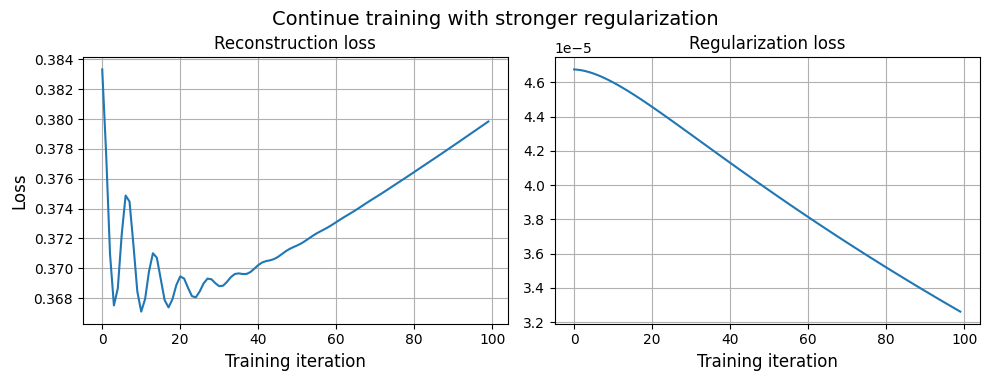

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(losses_recon_higher)
ax1.grid()
ax1.set_xlabel("Training iteration", size=12)
ax1.set_ylabel("Loss", size=12)
ax1.set_title("Reconstruction loss", size=12)

ax2.plot(losses_reg_higher)
ax2.grid()
ax2.set_xlabel("Training iteration", size=12)
ax2.set_title("Regularization loss", size=12)

fig.suptitle('Continue training with stronger regularization', size=14, y=0.94)
plt.tight_layout()
plt.savefig("fine_tuning_stronger_reg.pdf")

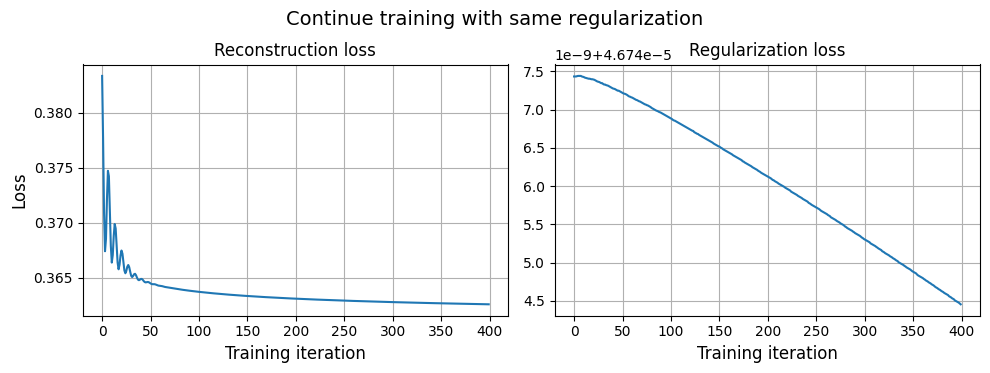

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(losses_recon_equal)
ax1.grid()
ax1.set_xlabel("Training iteration", size=12)
ax1.set_ylabel("Loss", size=12)
ax1.set_title("Reconstruction loss", size=12)

ax2.plot(losses_reg_equal)
ax2.grid()
ax2.set_xlabel("Training iteration", size=12)
ax2.set_title("Regularization loss", size=12)

fig.suptitle('Continue training with same regularization', size=14, y=0.92)
plt.tight_layout()
plt.savefig("fine_tuning_same_reg.pdf")

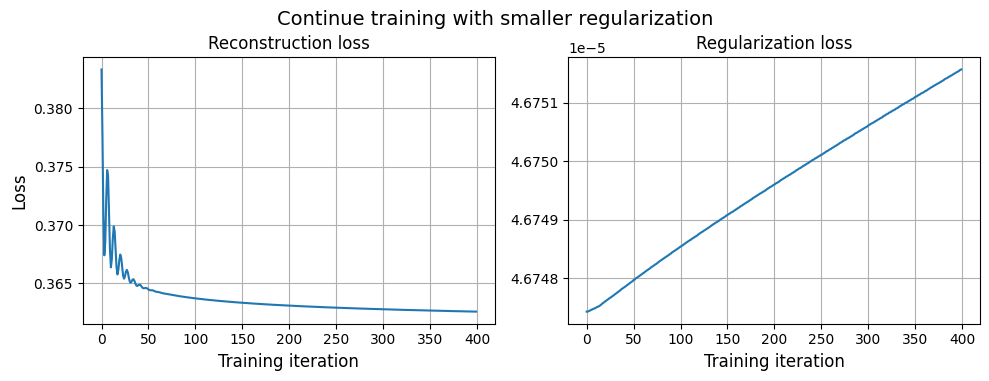

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(losses_recon_lower)
ax1.grid()
ax1.set_xlabel("Training iteration", size=12)
ax1.set_ylabel("Loss", size=12)
ax1.set_title("Reconstruction loss", size=12)

ax2.plot(losses_reg_lower)
ax2.grid()
ax2.set_xlabel("Training iteration", size=12)
ax2.set_title("Regularization loss", size=12)

fig.suptitle('Continue training with smaller regularization', size=14, y=0.94)
plt.tight_layout()
plt.savefig("fine_tuning_smaller_reg.pdf")